In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import plotly.graph_objects as go

# Specify your paths
preprocessed_path = r"C:\Users\RaymondCarpenter\Documents\GitHub\bigdatabowl2025\data\combined\final_tracking_data.csv"
model_path = r'data/models/route_predictor_model.pkl'
players_path = r'C:\Users\RaymondCarpenter\Documents\GitHub\bigdatabowl2025\data\raw\players.csv'

# Load the preprocessed data
df = pd.read_csv(preprocessed_path)

# Load player data to get position information
try:
    players_df = pd.read_csv(players_path)
    if 'displayName' not in players_df.columns:
        raise KeyError("The 'displayName' column is missing from players_df.")
    print("Loaded player data.")
except Exception as e:
    print(f"Failed to load player data from {players_path}: {e}")
    exit()

# Load the pre-trained XGBoost model
try:
    xgb_model = joblib.load(model_path)
    print("Loaded pre-trained XGBoost model.")
except Exception as e:
    print(f"Failed to load model from {model_path}: {e}")
    exit()

# Choose a gameId and playId to visualize
gameId = 2022091104
playId = 390

# Filter for the specific game and play
df_play = df[(df['gameId'] == gameId) & (df['playId'] == playId)]

# If no data is found for this play, print a message and exit
if df_play.empty:
    print(f"No data available for gameId: {gameId} and playId: {playId}.")
    exit()

# Merge in the 'position' and 'displayName' information using nflId
df_play = df_play.merge(players_df[['nflId', 'position', 'displayName']], on='nflId', how='left')

# Rename displayName_y to displayName (ensure this is accurate)
df_play.rename(columns={'displayName_y': 'displayName'}, inplace=True)

# Drop duplicate columns (like displayName_x)
df_play.drop(columns=[col for col in df_play.columns if col.endswith('_x') or col.endswith('_y')], inplace=True, errors='ignore')

# Drop duplicate columns (like displayName_x)
df_play.drop(columns=[col for col in df_play.columns if col.endswith('_x') or col.endswith('_y') and col != 'displayName'], inplace=True, errors='ignore')

# Aggregate features (group by frameId and nflId)
df_frame_features = df_play.groupby(['gameId', 'playId', 'frameId', 'nflId']).agg(
    x=('x', 'mean'),
    y=('y', 'mean'),
    s=('s', 'mean'),
    a=('a', 'mean'),
    dis=('dis', 'mean'),
    o=('o', 'mean'),
    dir=('dir', 'mean'),
    quarter=('quarter', 'first'),
    down=('down', 'first'),
    yardsToGo=('yardsToGo', 'first'),
    yardlineNumber=('yardlineNumber', 'first'),
    gameClock=('gameClock', 'first'),
    position=('position', 'first'),
    displayName=('displayName', 'first')  # Include displayName aggregation here
).reset_index()

# Calculate distance-based features
for frame_id in df_frame_features['frameId'].unique():
    frame_data = df_play[df_play['frameId'] == frame_id]
    distances = frame_data.groupby('nflId')[['x', 'y']].apply(lambda x: np.sqrt((x['x'] - x['x'].mean())**2 + (x['y'] - x['y'].mean())**2))
    df_frame_features.loc[df_frame_features['frameId'] == frame_id, 'min_distance'] = distances.min()
    df_frame_features.loc[df_frame_features['frameId'] == frame_id, 'max_distance'] = distances.max()
    df_frame_features.loc[df_frame_features['frameId'] == frame_id, 'mean_distance'] = distances.mean()
    df_frame_features.loc[df_frame_features['frameId'] == frame_id, 'std_distance'] = distances.std()

# Convert gameClock to numeric by converting MM:SS to seconds
try:
    df_frame_features['gameClock'] = df_frame_features['gameClock'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
except Exception as e:
    print(f"Failed to convert gameClock to numeric: {e}")
    exit()

# Extract features for the model
X = df_frame_features[['x', 'y', 's', 'a', 'dis', 'o', 'dir', 'quarter', 'down', 'yardsToGo', 'yardlineNumber', 'gameClock', 'min_distance', 'max_distance', 'mean_distance', 'std_distance']]

# If the dataframe is empty, exit the script
if X.empty:
    print(f"No data available for gameId: {gameId} and playId: {playId} after aggregation.")
    exit()


# Map route prediction indices to route names
route_map = {
    0: 'ANGLE',
    1: 'CORNER',
    2: 'CROSS',
    3: 'FLAT',
    4: 'GO',
    5: 'HITCH',
    6: 'IN',
    7: 'OUT',
    8: 'POST',
    9: 'SCREEN',
    10: 'SLANT',
    11: 'WHEEL'
}
# Make predictions using the loaded XGBoost model
probs = xgb_model.predict_proba(X)
df_frame_features['routePred'] = np.argmax(probs, axis=1)
df_frame_features['routeName'] = df_frame_features['routePred'].map(route_map)

route_colors = {
    'ANGLE': 'blue', 'CORNER': 'red', 'CROSS': 'green', 'FLAT': 'purple', 
    'GO': 'orange', 'HITCH': 'pink', 'IN': 'brown', 'OUT': 'yellow',
    'POST': 'cyan', 'SCREEN': 'magenta', 'SLANT': 'lime', 'WHEEL': 'black'
}


route_shapes = {
    "ANGLE": lambda x, y: [(x, y), (x + 10, y), (x + 5, y + 10)],
    "CORNER": lambda x, y: [(x, y), (x + 10, y), (x + 20, y + 10)],  
    "CROSS": lambda x, y: [(x, y), (x + 10, y + 5)],
    "FLAT": lambda x, y: [(x, y), (x + 5, y)],
    "GO": lambda x, y: [(x, y), (x + 25, y)],
    "HITCH": lambda x, y: [(x, y), (x + 5, y), (x + 5, y + 5)],
    "IN": lambda x, y: [(x, y), (x + 10, y)],
    "OUT": lambda x, y: [(x, y), (x + 10, y)],
    "POST": lambda x, y: [(x, y), (x + 15, y), (x + 20, y + 10)],
    "SCREEN": lambda x, y: [(x, y), (x, y + 5)],
    "SLANT": lambda x, y: [(x, y), (x + 5, y + 5)],
    "WHEEL": lambda x, y: [(x, y), (x + 5, y), (x + 10, y + 10)]
}

frames = []

# Pre-assign labels '1', '2', and '3' to wide receivers
wr_df = df_frame_features[df_frame_features['position'] == 'WR']  # Filter WRs
unique_wrs = wr_df[['nflId', 'displayName']].drop_duplicates().reset_index()

# Assign WR labels '1', '2', '3' based on their appearance
wr_labels = {nflId: str(i + 1) for i, nflId in enumerate(unique_wrs['nflId'])}

# Create frames for animation
frames = []
unique_frames = df_frame_features['frameId'].unique()

for frame_id in unique_frames:
    frame_data = []
    frame_df = df_frame_features[df_frame_features['frameId'] == frame_id]

    for row_index, row in frame_df.iterrows():
        x_start, y_start = row['x'], row['y']
        player_position = row['position']
        
        # Set color for dots (black for non-WR, route color for WR)
        color = 'black' if player_position != 'WR' else route_colors.get(row['routeName'], 'gray')

        # Add a dot for every player with WR labels (1, 2, 3)
        wr_text = wr_labels.get(row['nflId'], '') if player_position == 'WR' else ''
        frame_data.append(go.Scatter(
        x=[x_start],
        y=[y_start],
        mode='markers+text',
    marker=dict(size=10, color=color),  # Dot color
    text=wr_text,  # Pre-assigned WR numbers (1, 2, 3)
    textposition='middle center',
    textfont=dict(size=14, color="black", family="Arial", weight="bold"),  # Black and bold text
    hovertext=f"{row['displayName']}",  # Add WR display name to the hover text
    hoverinfo="text",  # Only show the hovertext
    showlegend=False  # Dots should not appear in the legend
))


        # Add WR route lines with predictions
        if player_position == 'WR' and row['routeName'] in route_shapes:
            points = route_shapes[row['routeName']](x_start, y_start)
            frame_data.append(go.Scatter(
                x=[p[0] for p in points],
                y=[p[1] for p in points],
                mode='lines',
                line=dict(color=color, width=2),
                name=f"{row['displayName']}",  # WR name in the legend
                showlegend=True
            ))

            # Add top-3 predictions for WRs
            if probs is not None and len(probs) > row_index:
                top_3_indices = np.argsort(probs[row_index])[-3:][::-1]  # Top 3 indices
                top_3_routes = [route_map[i] for i in top_3_indices]     # Top 3 routes
                top_3_probs = [probs[row_index][i] for i in top_3_indices]  # Corresponding probabilities

                for i, (route, prob) in enumerate(zip(top_3_routes, top_3_probs), start=1):
                    frame_data.append(go.Scatter(
                        x=[None],
                        y=[None],
                        mode='markers',
                        marker=dict(size=1, color=color),
                        name=f"Prediction {i}: {route} ({prob:.2%})",
                        showlegend=True
                    ))

    # Append the frame data
    frames.append(go.Frame(data=frame_data, name=f"Frame {frame_id}"))


# Create figure with the initial frame
initial_data = frames[0].data if frames else []
fig = go.Figure(
    data=initial_data,
    frames=frames
)

#yardline_number = df_frame_features['yardlineNumber'].iloc[0]
#line_of_scrimmage_x = yardline_number

# Grid line positions
grid_positions = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

# Add yard line numbers at the correct mirrored positions
yard_numbers = ['10', '20', '30', '40', '50', '40', '30', '20', '10']


# Ensure plays.csv is loaded for absoluteYardlineNumber and yardsToGo
plays_path = r'C:\Users\RaymondCarpenter\Documents\GitHub\bigdatabowl2025\data\raw\plays.csv'
plays_df = pd.read_csv(plays_path)

# Merge plays data with df_play for absoluteYardlineNumber and yardsToGo
df_play = df_play.merge(
    plays_df[['gameId', 'playId', 'absoluteYardlineNumber', 'yardsToGo']],
    on=['gameId', 'playId'],
    how='left'
)

# Calculate line of scrimmage
if 'absoluteYardlineNumber' in df_play.columns:
    line_of_scrimmage = df_play['absoluteYardlineNumber'].iloc[0]
else:
    # Fallback to x position of the center during line_set
    line_set_frame_id = df_play[df_play['event'] == 'line_set']['frameId'].min()
    center_position = df_play[(df_play['frameId'] == line_set_frame_id) & (df_play['position'] == 'C')]
    if not center_position.empty:
        line_of_scrimmage = center_position['x'].iloc[0]
    else:
        print("No line_set event or center position found. Defaulting to 0.")
        line_of_scrimmage = 0  # Default value if no data is available

# Calculate first down marker
if 'yardsToGo' in df_play.columns:
    first_down_marker = line_of_scrimmage + df_play['yardsToGo'].iloc[0]
else:
    print("No yardsToGo available. First down marker will not be added.")
    first_down_marker = None

# Add line of scrimmage to the figure
fig.add_trace(
    go.Scatter(
        x=[line_of_scrimmage, line_of_scrimmage],
        y=[0, 53.3],
        mode='lines',
        line=dict(color='blue', width=3, dash='dash'),
        name='Line of Scrimmage',
        showlegend=False,
        hoverinfo='none'
    )
)

# Add first down marker to the figure if calculated
if first_down_marker is not None:
    fig.add_trace(
        go.Scatter(
            x=[first_down_marker, first_down_marker],
            y=[0, 53.3],
            mode='lines',
            line=dict(color='yellow', width=3, dash='dash'),
            name='First Down Marker',
            showlegend=False,
            hoverinfo='none'
        )
    )


# Bottom yard numbers
fig.add_trace(
    go.Scatter(
        x=grid_positions,
        y=[5] * len(grid_positions),
        mode='text',
        text=yard_numbers,
        textfont_size=30,
        textfont_family="Courier New, monospace",
        textfont_color="#ffffff",
        showlegend=False,
        hoverinfo='none'
    )
)

# Top yard numbers
fig.add_trace(
    go.Scatter(
        x=grid_positions,
        y=[48.5] * len(grid_positions),
        mode='text',
        text=yard_numbers,
        textfont_size=30,
        textfont_family="Courier New, monospace",
        textfont_color="#ffffff",
        showlegend=False,
        hoverinfo='none'
    )
)

fig.update_layout(
    title="Offensive Player Routes - Frame by Frame (Up to SNAP)",
    autosize=False,
    width=1200,
    height=600,
    xaxis=dict(range=[-10, 110], autorange=False, tickmode='array', tickvals=np.arange(10, 121, 10).tolist(), showticklabels=False),
    yaxis=dict(range=[0, 53.3], autorange=False, showgrid=False, showticklabels=False),
    plot_bgcolor='#00B140',
    sliders=[dict(
        steps=[dict(method="animate", args=[[f"Frame {frame_id}"], {"mode": "immediate", "frame": {"duration": 500, "redraw": True}}], label=str(frame_id)) for frame_id in unique_frames],
        currentvalue={"prefix": "Frame: "},
        transition={"duration": 0},
    )],  
    updatemenus=[dict(
        type="buttons", 
        showactive=False,
        buttons=[
            dict(label="Play", method="animate", args=[None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]),
            dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
        ]
    )],
    showlegend=True,  # Show legend
    legend=dict(
        x=1.05,  # Position legend outside the plot area
        y=1,  # Position legend at the top
        traceorder='normal',
        font=dict(size=12)
    )
)


# Show the figure
fig.show()

Loaded player data.
Loaded pre-trained XGBoost model.
No yardsToGo available. First down marker will not be added.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the player play data
player_play_df = pd.read_csv(r'data\combined\final_player_play_data.csv')

# Load the plays data
plays_df = pd.read_csv(r'data\raw\plays.csv')

# Merge player play data with plays data to get down, distance, and quarter
merged_df = player_play_df.merge(
    plays_df[['gameId', 'playId', 'down', 'yardsToGo', 'quarter']],
    on=['gameId', 'playId'],
    how='left'
)

# Create a new column combining quarter and down
merged_df['quarter_down'] = 'Q' + merged_df['quarter'].astype(str) + ' ' + merged_df['down'].astype(str) + ' Down'

# Filter out rows where routeRan is NaN (if necessary)
merged_df = merged_df.dropna(subset=['routeRan'])

# Define route colors
route_colors = {
    'ANGLE': 'blue', 'CORNER': 'red', 'CROSS': 'green', 'FLAT': 'purple', 
    'GO': 'orange', 'HITCH': 'pink', 'IN': 'brown', 'OUT': 'yellow',
    'POST': 'cyan', 'SCREEN': 'magenta', 'SLANT': 'lime', 'WHEEL': 'black'
}

# Plot
plt.figure(figsize=(18, 10))
sns.countplot(
    x='quarter_down', 
    hue='routeRan', 
    data=merged_df, 
    palette=route_colors,
    order=sorted(merged_df['quarter_down'].unique())  # Ensure consistent order
)
plt.title('Route Distribution by Quarter and Down', fontsize=18)
plt.xlabel('Quarter and Down', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90, fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for easier comparison
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Route', fontsize=12)
plt.tight_layout()
plt.show()

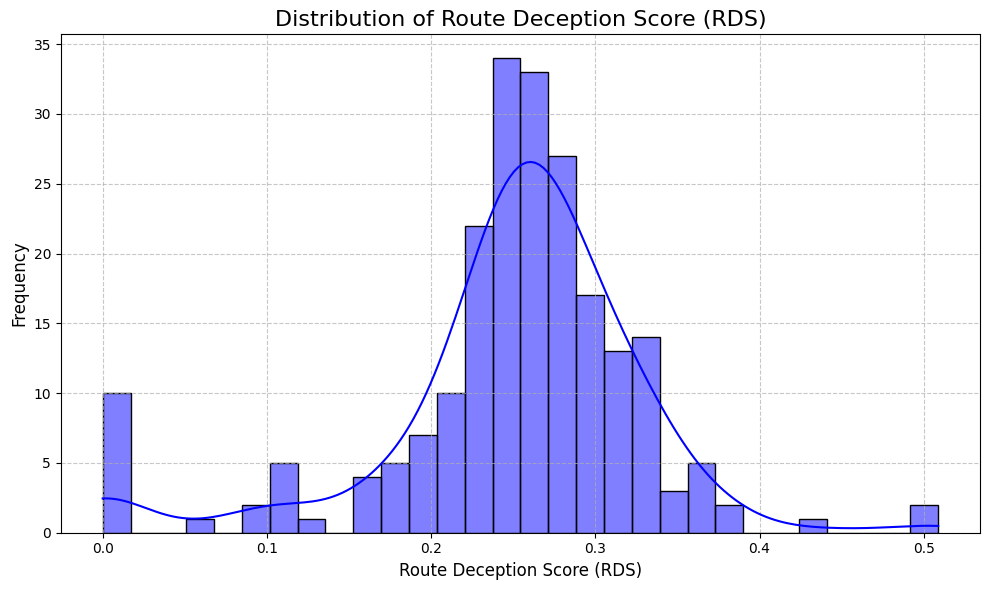

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the file path
rds_path = r'data\combined\route_deceptiveness_scores.csv'

# Check if the RDS file exists
if not os.path.exists(rds_path):
    raise FileNotFoundError(f"The file {rds_path} does not exist. Please ensure the RDS data has been generated.")

# Load the RDS data
rds_df = pd.read_csv(rds_path)

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(rds_df['route_deceptiveness_score'], bins=30, kde=True, color='blue')
plt.title('Distribution of Route Deception Score (RDS)', fontsize=16)
plt.xlabel('Route Deception Score (RDS)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

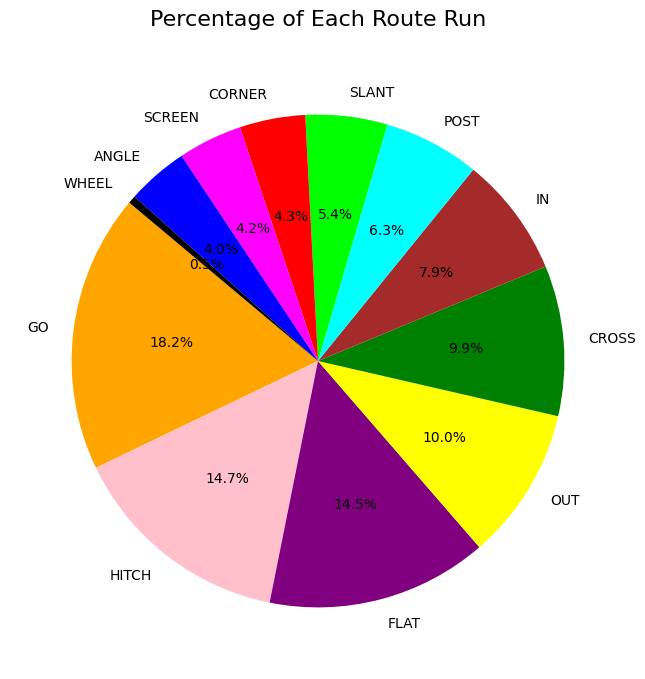

Predictions: [ 4  5 10 ...  1  4  4]


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Load the data
final_player_play_data = pd.read_csv('data/combined/final_player_play_data.csv')
x_test = pd.read_csv('data/combined/X_test.csv')

# Load the trained model
with open('data/models/route_predictor_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Calculate route percentages
route_counts = final_player_play_data['routeRan'].value_counts()
route_percentages = (route_counts / route_counts.sum()) * 100

# Define route colors
route_colors = {
    'ANGLE': 'blue', 'CORNER': 'red', 'CROSS': 'green', 'FLAT': 'purple', 
    'GO': 'orange', 'HITCH': 'pink', 'IN': 'brown', 'OUT': 'yellow',
    'POST': 'cyan', 'SCREEN': 'magenta', 'SLANT': 'lime', 'WHEEL': 'black'
}

# Visualization: Pie Chart
def create_pie_chart():
    plt.figure(figsize=(10, 8))
    plt.pie(
        route_percentages, 
        labels=route_percentages.index, 
        autopct='%1.1f%%', 
        colors=[route_colors[route] for route in route_percentages.index],
        startangle=140
    )
    plt.title('Percentage of Each Route Run', size=16, pad=20)
    plt.show()

# Make predictions using the model
def make_predictions():
    predictions = model.predict(x_test)
    print("Predictions:", predictions)

# Run the visualizations and predictions
create_pie_chart()
make_predictions()

C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_34788\644505321.py:13: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




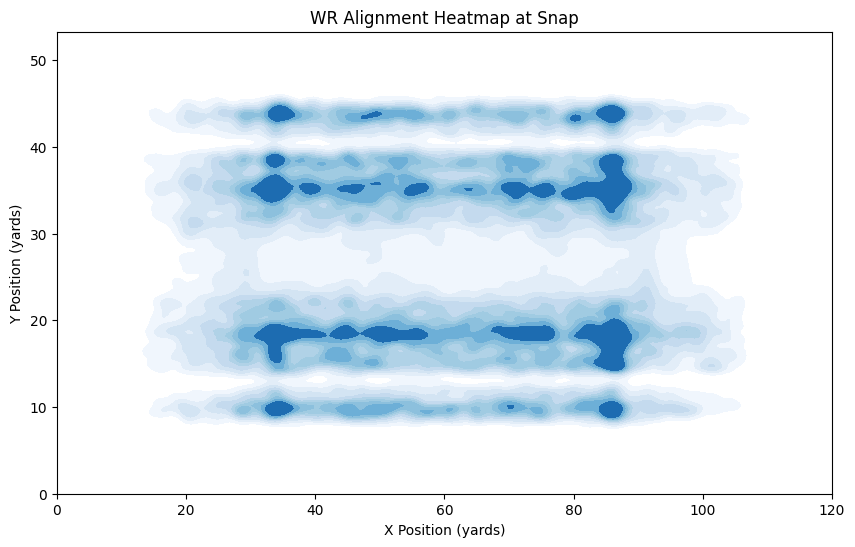

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

final_tracking_data = pd.read_csv(r"C:\Users\RaymondCarpenter\Documents\GitHub\bigdatabowl2025\data\combined\final_tracking_data.csv")
# Filter to just the SNAP or BEFORE_SNAP frame
snap_data = final_tracking_data[
    final_tracking_data['frameType'].isin(['SNAP', 'BEFORE_SNAP'])
]


plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=snap_data['x'], 
    y=snap_data['y'], 
    cmap="Blues", 
    fill=True, 
    shade=True, 
    bw_adjust=0.5
)
plt.title('WR Alignment Heatmap at Snap')
plt.xlabel('X Position (yards)')
plt.ylabel('Y Position (yards)')
plt.ylim(0, 53.3) 
plt.xlim(0, 120)   
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rds_merged = wr_rds_df.merge(
    final_tracking_data[['gameId', 'playId', 'down', 'yardsToGo']], 
    on=['gameId','playId'],
    how='left'
)

# Filter only WR if needed:
rds_merged = rds_merged[rds_merged['position'] == 'WR']

# Create a yardsToGo "bin" for easier grouping
bins = [0, 3, 7, 10, 15, 100]
labels = ["0-3", "4-7", "8-10", "11-15", "15+"]
rds_merged['yardsToGoBin'] = pd.cut(rds_merged['yardsToGo'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=rds_merged, 
    x='down', 
    y='deceptiveness_score', 
    hue='yardsToGoBin'
)
plt.title('Route Deceptiveness Score by Down & Distance')
plt.xlabel('Down')
plt.ylabel('Deceptiveness Score')
plt.legend(title='Yards To Go')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example approach to find time to throw:
# 1. Filter events for SNAP and PASS_FORWARD (or relevant pass event).
# 2. Calculate difference in timestamps for each play.

# Let's assume final_tracking_data has columns: [gameId, playId, event, time, nflId, routeRan, ...]
pass_events = final_tracking_data[final_tracking_data['event'].isin(['pass_forward', 'pass_shovel'])]
snap_events = final_tracking_data[final_tracking_data['event'] == 'snap']

# Merge them on gameId & playId, then compute time difference
merged_time = snap_events[['gameId','playId','time']].merge(
    pass_events[['gameId','playId','time']], 
    on=['gameId','playId'], 
    suffixes=('_snap','_pass')
)

# Convert time columns to Pandas datetime (if they aren't already)
merged_time['time_snap'] = pd.to_datetime(merged_time['time_snap'])
merged_time['time_pass'] = pd.to_datetime(merged_time['time_pass'])

merged_time['time_to_throw'] = (merged_time['time_pass'] - merged_time['time_snap']).dt.total_seconds()

# Now merge with route info
# Suppose route info is in 'player_play_data' or your wr_rds dataframe.
# For a single WR route per play, you might do:
time_route_df = merged_time.merge(
    player_play_data[['gameId','playId','nflId','routeRan']], 
    on=['gameId','playId'], 
    how='left'
)
# Filter to WR only if desired
# (Assuming you can also merge with 'players_df' to confirm position.)

plt.figure(figsize=(12, 6))
sns.violinplot(data=time_route_df, x='routeRan', y='time_to_throw', inner='quartile', cut=0)
plt.xticks(rotation=45, ha='right')
plt.title("Time to Throw Distribution by WR Route")
plt.xlabel("Route")
plt.ylabel("Time to Throw (seconds)")
plt.tight_layout()
plt.show()
